# Homework 2

### This is the solution of:
* Tor Djupman
* Isac Östman
* Felix Svedberg

$\newcommand{\dx}{\,\mathrm{d}x}$

## Problem 1 (Finite Difference Method in 2D)

 **a)** Let $\Omega = (0,1)\times (0,1)$.
For the functions $u_k(x,y) = \sin(2 \pi k x) \sin(2 \pi k y)$ with frequency $k \in \mathbb{N}$,
compute analytically the right-hand side $f$ and boundary data $g$
such that $u_k$ satisfies the Poisson problem
\begin{align*}
- \Delta u_k  &= f \quad \text{in } \Omega,
\\
 u_k &= g \quad \text{on } \partial \Omega.
\end{align*}

__ANSWER:__

For $k=2$, we have that
\begin{align}
    &\Delta u_{2} = \frac{\partial^{2} u_{2}}{\partial x^{2}} + \frac{\partial^{2} u_{2}}{\partial y^{2}}\\
    = &-(4\pi)^{2}\sin(4\pi x)\sin(4\pi y)-(4\pi)^{2}\sin(4\pi x)\sin(4\pi y) \\
    = & -32\pi^{2}\sin(4\pi x)\sin(4\pi y),
\end{align}
which means that 
\begin{align}
    f = 32\pi^{2}\sin(4\pi x)\sin(4\pi y).
\end{align}

In order to determine $g$, we have to consider what values of $x,y \in \partial \Omega$. On the boundary $\partial \Omega$, both $x$ and $y$ are either 0 or 1. Inserting the possible boundary values into $u_{2}$ we find that 
\begin{align}
    g = 0
\end{align}

**b)** Based on the code snippets below, implement a finite difference scheme to solve the problem given in a) for $k = 2$ numerically. For the computational grid, assume equally spaced subdivisions in $x$ and $y$ direction, starting with $N=8$ subintervals in each spatial direction. For $N = 8, 16, 32, 64$, compute and plot the finite difference solution $U$.

In [2]:
# Array and stuff 
import numpy as np
# Linear algebra solvers from scipy
import scipy.linalg as la
# Basic plotting routines from the matplotlib library 
import matplotlib.pyplot as plt
# We also need access to the colormaps for 3D plotting
from matplotlib import cm

#2D-PLOT
def plot2D(X, Y, Z, title=""):
    # Define a new figure with given size 
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_subplot(111, projection='3d') 
    surf = ax.plot_surface(X, Y, Z,             
                           rstride=1, cstride=1, # Sampling rates for the x and y input data
                           cmap=cm.viridis)      # Use the new fancy colormap viridis
    # Set initial view angle
    ax.view_init(30, 225)
    
    # Set labels and show figure
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_title(title)
    plt.show()




#FORCING FUNCTION GIVEN IN INSTRUCTIONS
def f_task1(x,y,k):
    f = 8*k**2*np.pi**2*np.sin(2*k*np.pi*x)*np.sin(2*k*np.pi*y)
    return f

#SOLVER
def fdm_poisson_2d_dense(N, k):

    ##### Compute right hand side####     
    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    
    # Evaluate f on the grid. 
    F_grid = np.zeros((N+1, N+1))
    #loop over interior
    for i in range(1, N):
        for j in range(1,N):
            #index [i,0] since np.ogrid produces a column vector followed by a row vector
            F_grid[i,j] = f_task1(x[i,0],y[0,j],k)
            
    #Set values on the boundary. -1 is the index of the last element. 
    #So first we set column 1 and N to zero and then rows 1 and N. 
    F_grid[0:N,[0, -1]] = 0;
    F_grid[[0,-1],0:N] = 0;

    # Now we define our rhs by flattening out F, making it a 1 dimensional array of length (N+1)*(N+1). 
    F = F_grid.ravel()  
    
    ####Create Matrix entries for unknowns associated with inner grid points.####
    
    #Map function to translate double index into a proper numbering
    def m(i,j):
        #map the 2D indexing to 1D to represent vector v
        k = (N+1)*j+i
        return k
    
    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N+1)**2
    
    # Allocate a (full!) MxM matrix filled with zeros
    A = np.zeros((M,M))
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,ri] = 4 # U_ij
            A[ri,m(i-1,j)] = -1  # U_{i-1,j}
            A[ri,m(i+1,j)] = -1    # U_{i+1,j}
            A[ri,m(i,j-1)] = -1    # U_{i,j-1}
            A[ri,m(i,j+1)] = -1    # U_{i,j+1}

    #Rescale interior
    A = A/hh
    
    ##### Incorporate boundary conditions #####
    # Boundary condition 
    for i in [0, N]:
        for j in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1 
    
    
    # Boundary condition 
    for j in [0, N]:
        for i in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1     

    
    
    ##### Solve linear systems ######
    # Solve linear algebra system 
    U = la.solve(A,F)
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid = U.reshape((N+1,N+1))
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,U_grid)

**c**) Compute the experimental order of convergence (EOC)
for $N = 16, 32, 64$ using $\max_{i} |U-u|$ as error measure. Summarize your results in a table. 
What convergence rate do you get? If you don't get an EOC very close to $2$, find the bugs in your code :)

__ANSWER:__

In table 1, we can clearly see that halving the grid size $h$ leads to a factor 4 decrease in the error, thus indicating EOC = 2. 

,Error
N,
8,0.233701
16,0.053029
32,0.012951
64,0.003219


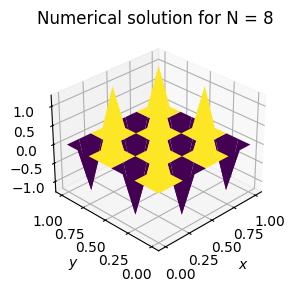

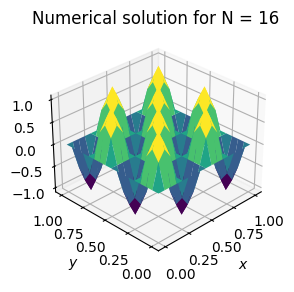

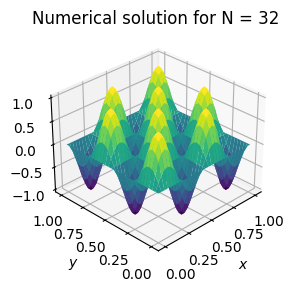

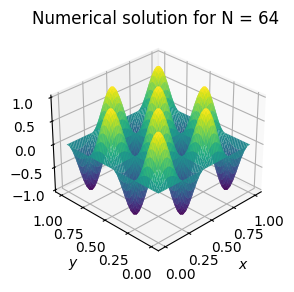

In [5]:
# c)
import pandas as pd
#Function U
def U_anal(x,y,k):
    u = np.sin(2*k*np.pi*x)*np.sin(2*k*np.pi*y)
    return u

#ERROR ANALYSIS
c = 0
error = np.zeros(4)
U_list = []
x_list = []
y_list = [] 
N_arr = np.array([8,16,32,64])
for N in N_arr:
    
    
    k = 2
    x,y,U = fdm_poisson_2d_dense(N, k)
    #plot2D(x, y, U, title="Numerical solution")
    #Append results to list in order to plot later
    U_list.append(U)
    x_list.append(x)
    y_list.append(y)
    
    
    ##EXACT SOLUTION 
    U_exact = np.zeros((N+1, N+1))
    
    for i in range(0, N+1):
            for j in range(0,N+1):
                U_exact[i,j] = U_anal(x[i,0],y[0,j],k)
                
    #plot2D(x, y, U_exact, title="Exact solution")
    
    #ERROR ANALYSIS
    E = np.abs(U_exact-U)
    error[c] = E.max()
    c = c+1


    
#TABLE
data = {"Error":error}

df = pd.DataFrame(data, index=N_arr)
df = df[["Error"]]
df = df.round(6)
df.index.name="N"
display(df.style.set_caption("Table 1: Error"))

#Plot figures
for i in range(0,len(N_arr)):
    plot2D(x_list[i], y_list[i], U_list[i], title=f"Numerical solution for N = {N_arr[i]}")

**d**) Test how large you can choose the resolution $N$ until either the problem takes too long (say 5 minutes) to compute or uses too much memory. Explain, what happens. Why does the problem
scale so badly with respect to $N$?

__ANSWER:__

From some test runs we found that it took 2 minutes to solve the system for N = 128 and >5 minutes for N = 256, indicating that the system becomes too computationally heavy to solve for some $128<N<256$. Why is this?



The size of matrix $A$ is $M \times M$, where $M = (N+1)^2$, which means that the size of $A$ scales  like
\begin{align}
    \dim(A) \sim N^{4}.
\end{align}
The number of operations needed to solve a linear system with general matrix $M$ of dimensions $N \times N$ scales like
\begin{align}
    Flops_{M} \sim N^{3}
\end{align}
Using LU-factoriztion. Some matrices require far fewer operations if the structure is well-defined and we are able to use a different algorithm. 
The matrix $A$ in question has a well-defined structure and might not need $\sim N^{3}$ many operations. But in the worst case scenario, the number of operations to solve a system of this size is
\begin{align}
    Flops_{A} \sim ((N+1)^2)^3 \sim N^{6}.
\end{align}

**e**) Based on your implementation, we now implement a finite difference using *sparse* matrices. Knowing the structure and entries of the matrix a priori, the most efficient 
realization would be based on (block) tridiagonal sparse matrices. 
But anticipating the forthcoming task of implementing schemes based on the finite element method, we will take a middle ground and simply switch to a flexible sparse matrix format which allows
for minimal adjustments of your previous solver implementation.
To this end, you shall incorporate the following code snippets into your code.

In [3]:
#Task 1e)

import scipy.sparse as sp
from scipy.sparse.linalg import spsolve


def fdm_poisson_2d_sparse(N,k):
    
    # Compute right-hand side     
    x,y = np.ogrid[0:1:(N+1)*1j, 0:1:(N+1)*1j]
    
    # Evaluate f on the grid. 
    F_grid = np.zeros((N+1, N+1))
    #loop over interior
    for i in range(1, N):
        for j in range(1,N):
            #index [i,0] since np.ogrid produces a column vector followed a row vector
            F_grid[i,j] = f_task1(x[i,0],y[0,j],k)
    #Set values on the boundary. -1 is the index of the last element. 
    #So first we set column 1 and N to zero and then rows 1 and N. 
    F_grid[0:N,[0, -1]] = 0;
    F_grid[[0,-1],0:N] = 0;


    # Now we define our rhs by flattening out F, making it a 1-dimensional array of length (N+1)*(N+1). 
    F = F_grid.ravel()  
    
    
    # To translate the grid based double index into a proper numbering, we define a 
    # small mapping function, assuming a row-wise numbering. 
    def m(i,j):
        #map the 2D indexing to 1D to represent vector v
        k = (N+1)*j+i
        return k
    
    # Total number of unknowns is M = (N+1)*(N+1)
    M = (N+1)**2
    
    # A new structure of matrix used in order to take the sparseness into account. 
    A = sp.dok_matrix((M, M))
    
    # Meshsize h
    h = 1/N
    hh = h*h
    
    # Compute matrix A entries by iterating over the *inner* grid points first.
    for i in range(1,N):      # i is the row number for the grid point
        for j in range(1,N):  # j is the column number for the grid point
            # Compute the index of the unknown at grid point (i,j). 
            # This is also the index of the row in matrix A we want to fill. 
            ri = m(i,j)       
            A[ri,ri] = 4 # U_ij
            A[ri,m(i-1,j)] = -1  # U_{i-1,j}
            A[ri,m(i+1,j)] = -1    # U_{i+1,j}
            A[ri,m(i,j-1)] = -1    # U_{i,j-1}
            A[ri,m(i,j+1)] = -1    # U_{i,j+1}

    #Rescale interior
    A = A/hh
    
    # Incorporate boundary conditions
    for i in [0, N]:
        for j in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1 
            
    
    
    # Boundary condition 
    for j in [0, N]:
        for i in range(0,N+1):
            # Define row index related to unknown U_m(i,j)
            ri = m(i,j)
            A[ri,ri] = 1   
            
    

    
    # Solve linear algebra system 
    A_csr = A.tocsr() 
    U = spsolve(A_csr, F)
    
    # Reshape the flat solution vector U to make it a grid function
    U_grid = U.reshape((N+1,N+1))
    
    # Return solution and x and y grid points for easy plotting
    return (x,y,U_grid)
    

**f**) Measure and compare the overall solution time for your two implementations 'fdm_poisson_2d_dense' and 'fdm_poisson_2d_sparse' by using the cell magic command %%timeit.
Here is a simple example of its usage. Simply execute the next cell.

In [4]:
#TASK 1f)
k = 2
N_arr = [8,16,32,64,128]
for N in N_arr:
    func1_time = %timeit -o -q fdm_poisson_2d_sparse(N,k)
    func2_time = %timeit -o -q fdm_poisson_2d_dense(N,k)
    print(f"Sparse time for N = {N} = {func1_time}")
    print(f"Dense time for N = {N} = {func2_time}")
    

Sparse time for N = 8 = 3.51 ms ± 415 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Dense time for N = 8 = 512 μs ± 12.4 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
Sparse time for N = 16 = 13.2 ms ± 996 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Dense time for N = 16 = 2.4 ms ± 130 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)
Sparse time for N = 32 = 51.2 ms ± 904 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Dense time for N = 32 = 34.7 ms ± 484 μs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Sparse time for N = 64 = 215 ms ± 5.46 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dense time for N = 64 = 1.25 s ± 24.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Sparse time for N = 128 = 913 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Dense time for N = 128 = 40.7 s ± 1.36 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


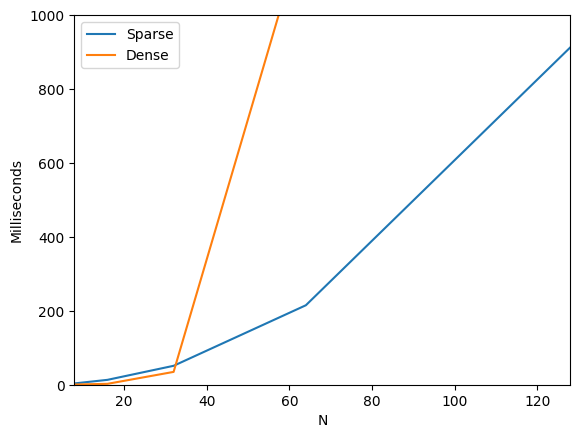

In [7]:
sparse_times = np.array([3.51, 13.2, 51.2, 215, 913])
dense_times = np.array([512.*10**(-3), 2.40, 34.7, 1250, 40700])

N_arr = [8,16,32,64,128]
plt.plot(N_arr, sparse_times)
plt.plot(N_arr, dense_times)
#plt.plot(N_arr, sparse_times/des_times)
plt.ylim([0, 1000])
plt.xlim([N_arr[0], N_arr[-1]])
plt.legend(["Sparse", "Dense"])
plt.xlabel("N")
plt.ylabel("Milliseconds")
plt.show()

__ANSWER:__

It is apparent from the figure that the new method is much more efficient when solving a sparse linear system. Worth noting is that the sparse solver is a little bit slower than the dense one for $N < 32$.

## Problem 2 (Quadrature Rules)

**a)** Write computer functions which compute the integral $\int_a^b f(x) \dx$ 
for a given $f$ and interval $[a,b]$ using the mid-point, trapezoidal and Simpson's rule.

**b)** For the monomial functions $p_i(x) = x^i$ and $i = 1,2,3$,
compute the integral $\int_0^1 p_i(x) \dx$ numerically using all three quadrature schemes.
Compute the exact integrals analytically and compute the quadrature error
$$
\text{err}(p_i, Q) = \left| \int_I p_i \dx - Q(p_i, I) \right|
$$

for each combination of quadrature rule and monomial. Summarize your result in
a table (quadrature rules as column header, monomials as row headers. You may use pandas library, see below.) Why does some quadrature error vanish? 

**c)** Divide $[0,1]$ into 2, 4 and then 8 equally spaced subintervals.
For those combinations of quadrature rules/monomials where the quadrature error does not vanish, compute a better approximation of the integral $\int_0^1 p_i(x) \dx$
by applying the corresponding quadrature rule separately on each of the 2, 4, 8 subintervals.
What experimental order of convergence do you observe for the quadrature rule/monomial pairs? 

__Answers:__

**b)** In Table 1 below, we see that all three quadrature schemes give an exact answer for a first-order monomial. As expected, Midpoint and Trapezoid are only exact to the first order, thus we get an error for the second and third orders. But, Simpsons is exact up to the third order, which is also shown in the table.

**c)** We want to determine the experimental order of convergence (EOC) for the Midpoint and Trapezoid rules when integrating second‐ and third‐order monomials. From Tables 2 and 3, we observe that when the step size h is halved, the error decreases by a factor of 4. Similarly, when we divide the step size by 4, the error decreases by a factor of 16. This pattern is observed for both methods and for both second- and -third-order monomials. Thus, this indicates that the error scales like h^2, which gives second-order convergence for both methods.

In [2]:
# a)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def mid_point(f, a, b, N):
    h = (b - a)/N
    g = 0
    for i in range(N):
        xm = h*(i + 0.5) + a
        g += f(xm)*h
    
    return g

def trapezoid(f, a, b, N):
    h = (b - a)/N
    g = 0
    x = np.linspace(a, b, N+1)
    for i in range(1,N+1):
        g += h/2*(f(x[i-1]) + f(x[i]))

    return g

def simpsons(f, a, b, N):
    h = (b - a)/N
    g = 0
    x = np.linspace(a, b, N+1)
    for i in range(1, N+1):
        xm = 0.5*(x[i-1] + x[i])
        g += h/6*(f(x[i-1]) + f(x[i]) + 4*f(xm))

    return g

In [6]:
# b)
a = 0
b = 1
N = 100
i_max = 3

P_analytic = np.zeros(i_max)
P_numeric = np.zeros((i_max,3))
err = np.zeros((i_max,3))

for i in range(1,i_max+1):
    p = lambda x : x**i
    P_analytic[i-1] = (b**(i+1) - a**(i+1))/(i+1)
    
    P_numeric[i-1,0] =  mid_point(p, a, b, N)
    P_numeric[i-1,1] = trapezoid(p, a, b, N)
    P_numeric[i-1, 2] = simpsons(p, a, b, N)

    for j in range(0,3):
        err[i-1,j] = P_analytic[i-1] - P_numeric[i-1,j]

data = {'midpoint': err[:,0],
        'Trapezoid': err[:,1],
        'Simpson': err[:,2]
        }
index = []
for i in range(1, i_max + 1):
    index.append(f"monomial_order_{i}")
df = pd.DataFrame(data, index=index)

display(df.style.set_caption("Table 1: Error").format('{:.3e}'))


,midpoint,Trapezoid,Simpson
monomial_order_1,0.000e+00,0.000e+00,0.000e+00
monomial_order_2,8.333e-06,-1.667e-05,0.000e+00
monomial_order_3,1.250e-05,-2.500e-05,0.000e+00


In [4]:
# c)

a = 0
b = 1
N = 100
i_max = 3

intervals = [2,4,8]
err_mid = np.zeros((2,4))
err_trap = np.zeros((2,4))

for i in range(0,2):
    err_mid[i, 0] = err[i+1, 0]
    err_trap[i, 0] = err[i+1, 1]

for i in range(1,3):
    p = lambda x : x**(i+1)
    for j,interval in enumerate(intervals):
        P_num_mid = 0
        P_num_trap = 0
        for k in range(0,interval):
            a_i = (b-a)*k/interval
            b_i =  (b-a)*(k+1)/interval
            
            P_num_mid +=  mid_point(p, a_i, b_i, N)
            P_num_trap += trapezoid(p, a_i, b_i, N)

        err_mid[i-1,j+1] = P_analytic[i] - P_num_mid
        err_trap[i-1,j+1] = P_analytic[i] - P_num_trap

# Table for error with different h
# Monomial order 2:
data = {'Error midpoint': err_mid[0,:],
        'Error Trapezoid': err_trap[0,:]
        }
index = []
index.append("h")
for i in [2, 4, 8]:
    index.append(f"h/{i}")

df = pd.DataFrame(data, index=index)
display(df.style.set_caption("Table 2: Monomial order 2.").format('{:.3e}'))

# Monomial order 3:
data = {'Error midpoint': err_mid[1,:],
        'Error Trapezoid': err_trap[1,:]
        }
index = []
index.append("h")
for i in [2, 4, 8]:
    index.append(f"h/{i}")

df = pd.DataFrame(data, index=index)
display(df.style.set_caption("Table 3: Monomial order 3.").format('{:.3e}'))

# Both has an EOC of h^2

,Error midpoint,Error Trapezoid
h,8.333e-06,-1.667e-05
h/2,2.083e-06,-4.167e-06
h/4,5.208e-07,-1.042e-06
h/8,1.302e-07,-2.604e-07


,Error midpoint,Error Trapezoid
h,1.250e-05,-2.500e-05
h/2,3.125e-06,-6.250e-06
h/4,7.812e-07,-1.562e-06
h/8,1.953e-07,-3.906e-07


## Problem 3 (Piecewise Linear Interpolation)

Let $0 = x_0 < x_1 < x_2 < \ldots < x_{N} = 1$ be a partition of the interval
$0\leq x\leq 1$ into $N$ subintervals of equal length $h$.  Moreover,
let $\{ \varphi_j\}_{j=0}^{N}$ be the set of hat basis functions of $V_h$
associated with the $N+1$ nodes $x_j$, $j = 0,1\ldots, N$, such that
\begin{align}
  \varphi_i(x_j) =
  \left \{ 
  \begin{array}{l}
    1, \quad \mbox{if } i = j, \\
    0, \quad \mbox{if } i \neq j.
  \end{array}
  \right .
\end{align}
The explicit expression for a hat function $\varphi_i(x)$ is given by 
\begin{align} 
  \varphi_i(x) =
  \left\{
  \begin{array}{ll}
    (x-x_{i-1})/h, &\mbox{if } x_{i-1} \leq x \leq x_i,\\
    (x_{i+1}-x)/h, & \mbox{if } x_i \leq x \leq x_{i+1},\\
    0, & \mbox{otherwise.} 
  \end{array}
  \right. 
\end{align}

**a)** Write a Python function that computes and returns the hat functions $\varphi_i$, $i=0,1,\dots,N$, where ${\texttt{xn}}$ is a vector containing the $N+1$ nodal points,
and $\texttt{x}$ is an array of points you want to evaluate hat function
$\varphi_i$ at. Then, plot $\varphi_2$ and $\varphi_N$ in partitions with $N=4,7,10$. (Use a finer sampling of $[0,1]$ than given by the nodal points for the plotting!)

### Code Snippet

**b**) Write a Python script ${\texttt { interp1d(f, xn, x)}}$, that computes the linear interpolant $\pi f_k\in V_h$, $k=1,2,3$ of 

* $f_1(x)=x\sin (3\pi x)$
* $f_2(x)=2-10x$
* $f_3(x)=x(1-x)$

by using your function ${\texttt {hatfun}}$. 

Hint: Recall that the interpolant is defined by
$$
\pi f(x) = \sum_{i=0}^{N} f(x_i) \varphi_i(x)
$$
Compute the error in the numerical solution using the $L^2$-norm
$
    \left(\| v \|_{L^2(I)}= \left( \int_I v^2 \right)^{1/2}\right)
$
and present the results in Log-Log plots (error versus $h$) using partitions with $N=2^2,2^3,...,2^6$. Do the errors behave as  
$$
\| f - \pi f \|_{L^2(I)}^2 \leqslant C \sum_{i=0}^{N} h_i^4 \| f'' \|_{L^2(I_i)}^2
$$
for all cases? If not, explain why. 
*Hint*: Use the code for the Simpson's formula to compute the $L^2$-norm per interval in the partition.

__ANSWER:__

The difference equation above states that the error between the real solution and the interpolation should grow on the scale of the fourth power or slower. In the solution below, we plot the error squared ($L^2$-norm) versus the mesh size h on a loglog-scale. We see that for the 1st and 3rd function, the slope of the curves are $>4$. The 2nd function is $-0.05$, which is almost zero, because it is a linear function and thus will be exact everywhere when we do the interpolation (the interpolation is piecewise linear). We however see that the error still has a slope, and this is because of small numerical artifacts.

But the 1st and 3rd are as mentioned greater than 4. This means that they do not follow the difference equation above, the error grows faster than $h^4$. The discrepancy most likely has to do with Simpson's rule. Since the 1st and 3rd functions are squared when calculating the $L^2$-norm, the integrands are of higher polynomial degree than 3, meaning that Simpson's cannot calculate them exactly. This means that we get an additional error, apart from the one from our interpolation, which makes the slope greater than 4. Had our $L^2$-norm been exact, we would probably have seen a slope $<4$.


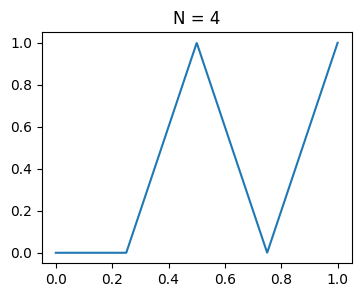

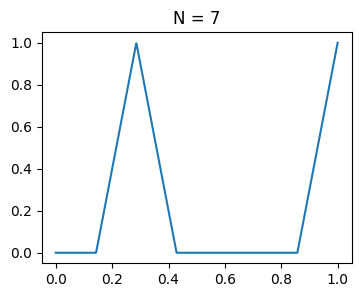

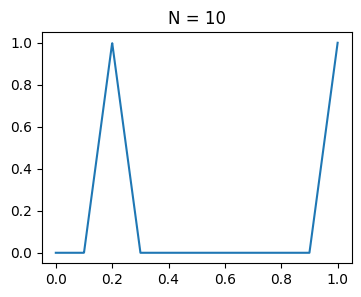

In [9]:
def hatfun(xn, i, x):
    y = np.zeros(x.size)
    N = xn.size-1
    
    # Make indexing work for zero dim array
    if x.ndim == 0:
        x = np.array([x])
    
    for j in range(0, y.size):
        # Left boundary
        if i == 0:
            if  xn[0] <= x[j] and x[j] <= xn[1]:
                y[j] = (xn[1] - x[j])/(xn[1] - xn[0])
        # Right boundar
        elif i == N:
            if  xn[N-1] <= x[j] and x[j] <= xn[N]:
                y[j] = (x[j] - xn[N-1])/(xn[N] - xn[N-1])
        # Interior point
        elif xn[i-1] <= x[j] and x[j] <= xn[i+1]:
            if x[j] <= xn[i]:
                y[j] = (x[j] - xn[i-1])/(xn[i] - xn[i-1])
            else:
                y[j] = (xn[i+1] - x[j])/(xn[i+1] - xn[i])
    return y

## Plotting 

N_values = [4, 7, 10]

x = np.linspace(0,1,1000)

for N in N_values:
    
    xn = np.linspace(0,1,N+1)
    
    phi = hatfun(xn,2,x)
    phi += hatfun(xn,N,x)
    
    plt.figure(figsize=(4, 3))
    plt.plot(x,phi)
    plt.title(f"N = {N}")

In [13]:
# New simpsons for taking a list as input
def simpsons(f, a, b):  
    N = f.size
    h = (b - a)/(N - 1)
    g = (h/3) * (f[0] + 2*np.sum(f[2:N-2:2]) + 4*np.sum(f[1:N-1:2]) + f[N-1])
    
    return g

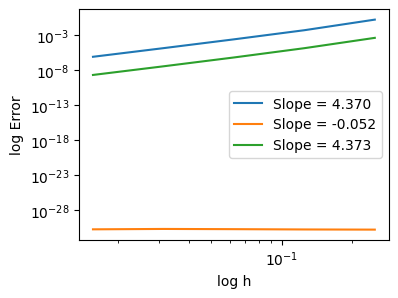

In [16]:
# function that calculates the interpolant
# of the func. f using hatfun()
def interp1d(f,xn,x):

    pi_f = np.zeros(x.size)
    

    for i in range(xn.size):
        pi_f += hatfun(xn,i,x)*f(xn[i])
        
    return pi_f

# Function that calculates the L^2 norm of the error
def calc_error(f,pi_f,N,x):  
        
    func = f(x)
    
    e = func - pi_f
    
    e_sqr = e**2
    
    L2norm = simpsons(e_sqr,0,1)
    
    return L2norm
    
# Partitions
x = np.linspace(0,1,999)
N_list = np.array([2**2, 2**3, 2**4, 2**5, 2**6])
error_N = np.zeros((3,N_list.size))

# Functions
f1 = lambda x : x*np.sin(3*np.pi*x)
f2 = lambda x : 2 - 10*x
f3 = lambda x : x*(1 - x)
funs = [f1,f2,f3]

# Calculate error for each function and N
for j in range(0,3):
    for i in range(N_list.size):
        xn = np.linspace(0,1,N_list[i])
        pi_f = interp1d(funs[j],xn,x)
    
        error_N[j,i] = calc_error(funs[j],pi_f,N_list[i],x)

q = np.zeros(3)
plt.figure(figsize=(4,3))
for i in range(len(funs)):
    q[i] = np.polyfit(np.log(1/N_list),np.log(error_N[i,:]),1)[0]
    plt.loglog(1/N_list,error_N[i,:])

plt.xlabel("log h")
plt.ylabel("log Error")
plt.legend([f"Slope = {q[0]:.3f}", f"Slope = {q[1]:.3f}",f"Slope = {q[2]:.3f}"])
plt.show()